In [1]:
# --- QUESTION 3 STEP 1: ---

# 1. Install Core Scientific Libraries (Standard PyPI)
# We lock these versions to prevent the "NumPy 2.x vs Scipy" crash.
print("1. Installing Standard Libraries...")
!pip install "numpy<2" "scipy<1.13" "pandas<2.2" "matplotlib<3.8" > /dev/null

# 2. Install PyTorch Stack (CUDA Index)
# We use PyTorch 2.2.0 because it is compatible with TorchText 0.17.0
print("2. Installing PyTorch 2.2.0 (CUDA)...")
!pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 --index-url https://download.pytorch.org/whl/cu121 > /dev/null

# 3. Install TorchText & NLP Tools
print("3. Installing TorchText & NLP Tools...")
!pip install torchtext==0.17.0 transformers==4.38.2 datasets scikit-learn portalocker spacy torchmetrics > /dev/null

# 4. Download Language Models
print("4. Downloading Spacy Models...")
!python -m spacy download en_core_web_sm > /dev/null
!python -m spacy download de_core_news_sm > /dev/null

# Re-install TorchText and Portalocker
!pip install torchtext==0.17.0 portalocker > /dev/null

import torch
print(f"\n✅ Setup Complete.")
print(f"PyTorch Version: {torch.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

1. Installing Standard Libraries...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.1.4 which is incompatible.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.5 which is incompatible.
google-colab 1.0.0 requires tornado==6.4.2, but you have tornado 6.5.2 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.12.0 which is incompatible.
dopamine-rl 4.1.2 

In [2]:
# --- STEP 2: Data Pipeline for Transformers ---
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import spacy.cli

# 0. Verify Spacy Models (Safety Check)
print("0. Verifying Spacy Models...")
try:
    spacy.load("en_core_web_sm")
    spacy.load("de_core_news_sm")
except OSError:
    print("   ⚠️ Models missing. Downloading...")
    spacy.cli.download("en_core_web_sm")
    spacy.cli.download("de_core_news_sm")

# 1. Load Dataset
print("1. Loading Multi30k...")
dataset = load_dataset("bentrevett/multi30k")
train_data = list(dataset['train'])
val_data = list(dataset['validation'])
test_data = list(dataset['test'])

# 2. Tokenizers
print("2. Setting up Tokenizers...")
tokenizer_de = get_tokenizer('spacy', language='de_core_news_sm')
tokenizer_en = get_tokenizer('spacy', language='en_core_web_sm')

# 3. Build Vocabularies
print("3. Building Vocabularies...")
def yield_tokens(data_iter, language):
    tokenizer = tokenizer_de if language == 'de' else tokenizer_en
    for item in data_iter:
        yield tokenizer(item[language])

specials = ["<unk>", "<pad>", "<bos>", "<eos>"]
vocab_src = build_vocab_from_iterator(yield_tokens(train_data, 'de'), specials=specials, min_freq=2)
vocab_tgt = build_vocab_from_iterator(yield_tokens(train_data, 'en'), specials=specials, min_freq=2)

vocab_src.set_default_index(vocab_src["<unk>"])
vocab_tgt.set_default_index(vocab_tgt["<unk>"])

print(f"   German Vocab: {len(vocab_src)} | English Vocab: {len(vocab_tgt)}")

# 4. Collate & Loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BOS_IDX = vocab_src['<bos>']
EOS_IDX = vocab_src['<eos>']
PAD_IDX = vocab_src['<pad>'] # We assume PAD is the same index in both, usually 1

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for item in batch:
        src_tokens = [vocab_src[token] for token in tokenizer_de(item['de'])]
        tgt_tokens = [vocab_tgt[token] for token in tokenizer_en(item['en'])]
        
        src_batch.append(torch.tensor([BOS_IDX] + src_tokens + [EOS_IDX], dtype=torch.long))
        tgt_batch.append(torch.tensor([BOS_IDX] + tgt_tokens + [EOS_IDX], dtype=torch.long))
        
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch.to(device), tgt_batch.to(device)

print("4. Creating DataLoaders...")
BATCH_SIZE = 128
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("✅ Q3 Data Ready.")

0. Verifying Spacy Models...
1. Loading Multi30k...


README.md: 0.00B [00:00, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

val.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

2. Setting up Tokenizers...
3. Building Vocabularies...
   German Vocab: 8014 | English Vocab: 6191
4. Creating DataLoaders...
✅ Q3 Data Ready.


In [3]:
# --- STEP 3: Define Transformer Architecture & Utils ---
import torch.nn as nn
import torch.nn.functional as F
import math

# 1. Positional Encoding
# Injects information about the relative or absolute position of tokens
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [seq_len, batch_size, d_model]
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# 2. The Transformer Seq2Seq Model
class Seq2SeqTransformer(nn.Module):
    def __init__(self, 
                 num_encoder_layers, num_decoder_layers, 
                 emb_size, nhead, 
                 src_vocab_size, tgt_vocab_size, 
                 dim_feedforward, dropout=0.1):
        super(Seq2SeqTransformer, self).__init__()
        
        self.transformer = nn.Transformer(d_model=emb_size,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = nn.Embedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        self.emb_size = emb_size

    def forward(self, src, trg, src_mask, trg_mask, src_padding_mask, trg_padding_mask, memory_key_padding_mask):
        # Embed + Positional Encode
        src_emb = self.positional_encoding(self.src_tok_emb(src) * math.sqrt(self.emb_size))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg) * math.sqrt(self.emb_size))
        
        # Transformer Pass
        outs = self.transformer(src_emb, tgt_emb, src_mask, trg_mask, None,
                                src_padding_mask, trg_padding_mask, memory_key_padding_mask)
        
        return self.generator(outs)

    def encode(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src) * math.sqrt(self.emb_size)), src_mask)

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt) * math.sqrt(self.emb_size)), memory, tgt_mask)

# 3. Mask Generation Helper
# Transformers need masks to ignore padding and prevent looking ahead
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt, pad_idx):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_padding_mask = (src == pad_idx).transpose(0, 1)
    tgt_padding_mask = (tgt == pad_idx).transpose(0, 1)
    
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

print("✅ Transformer Architecture & Utils Defined.")

✅ Transformer Architecture & Utils Defined.


In [4]:
# --- STEP 4 (FIXED): Transformer Training Functions ---
import time

def train_transformer(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for i, (src, trg) in enumerate(iterator):
        # src, trg are already [seq_len, batch_size]
        # We DO NOT transpose them.
        
        trg_input = trg[:-1, :] # Remove <eos> from input (slice first dim)
        
        # Create Masks
        # src: [src_len, batch], trg_input: [trg_len, batch]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg_input, PAD_IDX)
        
        optimizer.zero_grad()
        
        # Forward Pass
        logits = model(src, trg_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        # Reshape for Loss
        # trg[1:]: Remove <bos> (target output)
        tgt_out = trg[1:, :].reshape(-1) 
        logits = logits.reshape(-1, logits.shape[-1])
        
        loss = criterion(logits, tgt_out)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate_transformer(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            # No transpose needed
            trg_input = trg[:-1, :]
            
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg_input, PAD_IDX)
            
            logits = model(src, trg_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
            
            tgt_out = trg[1:, :].reshape(-1)
            logits = logits.reshape(-1, logits.shape[-1])
            
            loss = criterion(logits, tgt_out)
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

print("✅ Transformer Training Loop Fixed.")

✅ Transformer Training Loop Fixed.


In [5]:
# --- Step 4.5: Load GloVe & Align Model Dimensions ---
from torchtext.vocab import GloVe

# 1. Load GloVe Vectors (200d)
# We use 200d because it divides cleanly by 8 heads (200/8 = 25)
print("Loading GloVe Vectors (6B, 200d)...")
glove = GloVe(name='6B', dim=200)

# 2. Create Embedding Matrix
print("Creating Embedding Matrix for Target Vocab...")
emb_dim = 200
embedding_matrix_tgt = torch.zeros((len(vocab_tgt), emb_dim))
found = 0

for i, token in enumerate(vocab_tgt.get_itos()):
    vec = glove.get_vecs_by_tokens(token)
    if torch.sum(vec) != 0:
        embedding_matrix_tgt[i] = vec
        found += 1
    else:
        # Initialize unknown words randomly
        embedding_matrix_tgt[i] = torch.randn(emb_dim)

print(f"✅ GloVe Ready. Found {found}/{len(vocab_tgt)} words.")

Loading GloVe Vectors (6B, 200d)...


.vector_cache/glove.6B.zip: 862MB [02:42, 5.31MB/s]                               
100%|█████████▉| 399999/400000 [00:29<00:00, 13443.62it/s]


Creating Embedding Matrix for Target Vocab...
✅ GloVe Ready. Found 5595/6191 words.


In [6]:
# --- STEP 5 : Train Transformer + Static GloVe ---
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)
    return elapsed_mins, elapsed_secs


# 1. Hyperparameters (UPDATED to match GloVe 200d)
SRC_VOCAB_SIZE = len(vocab_src)
TGT_VOCAB_SIZE = len(vocab_tgt)
EMB_SIZE = 200 # <--- CHANGED from 256 to 200 to match GloVe
NHEAD = 8      # 200 / 8 = 25 (Divides evenly, unlike 300)
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 10

print(f"--- 🚀 Starting Transformer + GloVe Training ({NUM_EPOCHS} Epochs) ---")

# 2. Initialize Model (With new 200d size)
model_transformer = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, 
    EMB_SIZE, NHEAD, 
    SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, 
    FFN_HID_DIM
).to(device)

# 3. Load & Freeze GloVe Embeddings (Target Side)
# Now the sizes will match (200 -> 200)
model_transformer.tgt_tok_emb.weight.data.copy_(embedding_matrix_tgt)
model_transformer.tgt_tok_emb.weight.requires_grad = False 
print("✅ GloVe embeddings loaded and frozen.")

# 4. Initialize Weights (Xavier)
for p in model_transformer.parameters():
    if p.dim() > 1 and p.requires_grad:
        nn.init.xavier_uniform_(p)

# 5. Optimizer & Loss
optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

print(f"Model Parameters: {sum(p.numel() for p in model_transformer.parameters() if p.requires_grad):,}")

# 6. Training Loop
best_val_loss = float('inf')
history_transformer = {'train_loss': [], 'val_loss': []}

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    train_loss = train_transformer(model_transformer, train_dataloader, optimizer, loss_fn, 1)
    val_loss = evaluate_transformer(model_transformer, val_dataloader, loss_fn)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_transformer.state_dict(), 'model_transformer_glove.pt')
    
    history_transformer['train_loss'].append(train_loss)
    history_transformer['val_loss'].append(val_loss)
    
    train_ppl = math.exp(train_loss)
    val_ppl = math.exp(val_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. PPL: {val_ppl:.3f}')

print("--- Transformer + GloVe Training Complete ---")

--- 🚀 Starting Transformer + GloVe Training (10 Epochs) ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


✅ GloVe embeddings loaded and frozen.


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Model Parameters: 5,534,263


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 01 | Time: 0m 15s
	Train Loss: 4.695 | Train PPL: 109.348
	 Val. Loss: 3.502 |  Val. PPL: 33.197
Epoch: 02 | Time: 0m 14s
	Train Loss: 3.264 | Train PPL: 26.156
	 Val. Loss: 2.721 |  Val. PPL: 15.203
Epoch: 03 | Time: 0m 14s
	Train Loss: 2.712 | Train PPL: 15.056
	 Val. Loss: 2.335 |  Val. PPL: 10.326
Epoch: 04 | Time: 0m 14s
	Train Loss: 2.357 | Train PPL: 10.558
	 Val. Loss: 2.128 |  Val. PPL: 8.400
Epoch: 05 | Time: 0m 14s
	Train Loss: 2.102 | Train PPL: 8.184
	 Val. Loss: 1.928 |  Val. PPL: 6.878
Epoch: 06 | Time: 0m 15s
	Train Loss: 1.904 | Train PPL: 6.714
	 Val. Loss: 1.805 |  Val. PPL: 6.083
Epoch: 07 | Time: 0m 15s
	Train Loss: 1.748 | Train PPL: 5.745
	 Val. Loss: 1.741 |  Val. PPL: 5.705
Epoch: 08 | Time: 0m 15s
	Train Loss: 1.618 | Train PPL: 5.045
	 Val. Loss: 1.664 |  Val. PPL: 5.279
Epoch: 09 | Time: 0m 15s
	Train Loss: 1.509 | Train PPL: 4.520
	 Val. Loss: 1.635 |  Val. PPL: 5.130
Epoch: 10 | Time: 0m 15s
	Train Loss: 1.417 | Train PPL: 4.126
	 Val. Loss: 1.589 |

In [7]:
# --- STEP 6 : Define BERT-Fused Transformer ---
from transformers import BertModel

class BertSeq2SeqTransformer(nn.Module):
    def __init__(self, 
                 num_decoder_layers, 
                 emb_size, nhead, 
                 tgt_vocab_size, 
                 dim_feedforward, dropout=0.1):
        super(BertSeq2SeqTransformer, self).__init__()
        
        print("Loading BERT (Multilingual)...")
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        
        for param in self.bert.parameters():
            param.requires_grad = False
            
        self.bert_hidden_size = 768 
        
        decoder_layer = nn.TransformerDecoderLayer(d_model=768, nhead=nhead, 
                                                 dim_feedforward=dim_feedforward, 
                                                 dropout=dropout, batch_first=False)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.generator = nn.Linear(768, tgt_vocab_size)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, 768)
        self.positional_encoding = PositionalEncoding(768, dropout=dropout)

    def forward(self, src, trg, tgt_mask, tgt_padding_mask, src_padding_mask):
        # src: [batch, seq_len]
        # trg: [seq_len, batch]
        
        # 1. Encoder Pass (BERT)
        # Convert PyTorch mask (True=Pad) to HF mask (0=Pad, 1=Keep)
        hf_attention_mask = (~src_padding_mask).long()
        

        # src_padding_mask comes in as [batch, seq_len]. BERT wants [batch, seq_len].
        # We keep it as is.
        
        bert_output = self.bert(input_ids=src, attention_mask=hf_attention_mask)
        
        # memory: [batch, seq_len, 768] -> Transpose to [seq_len, batch, 768] for Decoder
        memory = bert_output.last_hidden_state.transpose(0, 1)
        
        # 2. Decoder Pass
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg) * math.sqrt(768))
        
        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask=tgt_mask, 
                                        tgt_key_padding_mask=tgt_padding_mask,
                                        memory_key_padding_mask=src_padding_mask)
        
        return self.generator(outs)

print("✅ BERT-Transformer Architecture Fixed.")

✅ BERT-Transformer Architecture Fixed.


In [8]:
# --- FIX: BERT Translation Helper ---

def translate_sentence_bert(model, sentence, trg_vocab, device, max_len=50):
    model.eval()
    
    # 1. Tokenize Source with BERT (Correct Way)
    if isinstance(sentence, str):
        # BERT tokenizer adds [CLS] and [SEP] automatically
        src_indices = tokenizer_bert.encode(sentence, add_special_tokens=True)
    else:
        # If already list of words (not ideal for BERT, but handleable)
        sentence_str = " ".join(sentence)
        src_indices = tokenizer_bert.encode(sentence_str, add_special_tokens=True)

    src = torch.LongTensor(src_indices).unsqueeze(1).to(device) # [seq, 1]
    
    # 2. Create Dummy Mask (No masking needed for inference of 1 sentence)
    # In our class, we expect src_padding_mask of shape [batch, seq]
    # Here batch=1. src is [seq, 1].
    # We need to pass a dummy mask of False (not padding)
    src_padding_mask = torch.zeros((1, len(src_indices)), dtype=torch.bool).to(device)
    
    # 3. Encode
    memory = model.encode(src, src_padding_mask)
    
    # 4. Greedy Decode
    # Start with <bos> from Target Vocab
    start_symbol = trg_vocab['<bos>']
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    
    for i in range(max_len-1):
        memory = memory.to(device)
        
        # Target Mask
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(device)
        
        # Decode
        # We need to pass dummy masks for the padding arguments
        tgt_padding_mask = torch.zeros((1, ys.size(0)), dtype=torch.bool).to(device)
        
        # Note: Our model.decode might expect different arguments depending on definition
        # Let's look at the class: def decode(self, tgt, memory, tgt_mask):
        out = model.decode(ys, memory, tgt_mask)
        
        prob = model.generator(out[-1, :])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        
        if next_word == trg_vocab['<eos>']:
            break
            
    # Convert to words
    return [trg_vocab.lookup_token(i) for i in list(ys.flatten().cpu().numpy())]

print("✅ BERT Translation Function Defined.")

✅ BERT Translation Function Defined.


In [9]:
# --- STEP 7 : Data Pipeline for BERT-Transformer ---
from transformers import BertTokenizer
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# Load BERT Tokenizer
print("Loading BERT Tokenizer...")
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define Special Indices (The Fix)
# We grab these from the vocab we built in Step 2
TGT_BOS_IDX = vocab_tgt['<bos>']
TGT_EOS_IDX = vocab_tgt['<eos>']
TGT_PAD_IDX = vocab_tgt['<pad>']

# Define BERT Collate Function
def collate_fn_bert(batch):
    src_batch, tgt_batch = [], []
    for item in batch:
        # Source (German): Tokenize with BERT
        # tokenizer_bert.encode adds [CLS] and [SEP] automatically
        src_encoded = tokenizer_bert.encode(item['de'], add_special_tokens=True) 
        src_batch.append(torch.tensor(src_encoded, dtype=torch.long))
        
        # Target (English): Tokenize with Spacy 
        tgt_tokens = [vocab_tgt[token] for token in tokenizer_en(item['en'])]
        tgt_tensor = torch.tensor([TGT_BOS_IDX] + tgt_tokens + [TGT_EOS_IDX], dtype=torch.long)
        tgt_batch.append(tgt_tensor)
        
    # Pad
    # BERT uses its own pad token ID (usually 0)
    BERT_PAD_IDX = tokenizer_bert.pad_token_id
    src_batch = pad_sequence(src_batch, padding_value=BERT_PAD_IDX)
    
    # Target padding uses our vocab's PAD_IDX
    tgt_batch = pad_sequence(tgt_batch, padding_value=TGT_PAD_IDX)
    
    return src_batch.to(device), tgt_batch.to(device)

# 4. Create BERT DataLoaders
print("Creating BERT DataLoaders...")
# We keep batch size manageable for BERT
train_dataloader_bert = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=collate_fn_bert)
val_dataloader_bert = DataLoader(val_data, batch_size=128, shuffle=False, collate_fn=collate_fn_bert)
test_dataloader_bert = DataLoader(test_data, batch_size=128, shuffle=False, collate_fn=collate_fn_bert)

print(" BERT Pipeline Ready.")

Loading BERT Tokenizer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Creating BERT DataLoaders...
 BERT Pipeline Ready.


In [10]:
# --- STEP 8 : Train Transformer + BERT ---
import math
import time

# Hyperparameters
EMB_SIZE = 768 
NHEAD = 8
FFN_HID_DIM = 2048 
BATCH_SIZE = 128
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 10 
LR = 0.0001

print(f"--- 🚀 Starting Transformer + BERT Training ({NUM_EPOCHS} Epochs) ---")

# Initialize Model
model_bert = BertSeq2SeqTransformer(
    NUM_DECODER_LAYERS, 
    EMB_SIZE, NHEAD, 
    len(vocab_tgt), 
    FFN_HID_DIM
).to(device)

optimizer = torch.optim.Adam(model_bert.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss(ignore_index=TGT_PAD_IDX)

# Custom Mask Creator for BERT
def create_mask_bert(src, tgt):

    
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    
    # BERT PAD ID
    bert_pad_idx = tokenizer_bert.pad_token_id
    
    # Create Padding Masks
    # We need [Batch, Seq_Len] for the Transformer mask arguments
    # src is [Seq, Batch], so (src==pad) is [Seq, Batch]. Transpose -> [Batch, Seq]
    src_padding_mask = (src == bert_pad_idx).transpose(0, 1)
    tgt_padding_mask = (tgt == TGT_PAD_IDX).transpose(0, 1)
    
    return tgt_mask, src_padding_mask, tgt_padding_mask

# Training Function
def train_bert_epoch(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for i, (src, trg) in enumerate(iterator):

        # Slice the Sequence Dimension (Dim 0), not Batch (Dim 1)
        trg_input = trg[:-1, :] 
        
        # Create Masks (using untransposed inputs which are [seq, batch])
        tgt_mask, src_padding_mask, tgt_padding_mask = create_mask_bert(src, trg_input)
        
        optimizer.zero_grad()
        
        # Transpose src to [Batch, Seq] for BERT Model
        src_batch_first = src.transpose(0, 1)
        
        # Forward Pass
        logits = model(src_batch_first, trg_input, tgt_mask, tgt_padding_mask, src_padding_mask)
        
        # Reshape for Loss
        tgt_out = trg[1:, :].reshape(-1)
        logits = logits.reshape(-1, logits.shape[-1])
        
        loss = criterion(logits, tgt_out)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

# Evaluation Function
def evaluate_bert_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):

            trg_input = trg[:-1, :]
            tgt_mask, src_padding_mask, tgt_padding_mask = create_mask_bert(src, trg_input)
            src_batch_first = src.transpose(0, 1)
            
            logits = model(src_batch_first, trg_input, tgt_mask, tgt_padding_mask, src_padding_mask)
            
            tgt_out = trg[1:, :].reshape(-1)
            logits = logits.reshape(-1, logits.shape[-1])
            
            loss = criterion(logits, tgt_out)
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

# --- RUN TRAINING ---
best_val_loss = float('inf')
history_bert = {'train_loss': [], 'val_loss': []}

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    train_loss = train_bert_epoch(model_bert, train_dataloader_bert, optimizer, loss_fn, 1)
    val_loss = evaluate_bert_epoch(model_bert, val_dataloader_bert, loss_fn)
    
    end_time = time.time()
    mins, secs = epoch_time(start_time, end_time)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_bert.state_dict(), 'model_transformer_bert.pt')
    
    train_ppl = math.exp(train_loss)
    val_ppl = math.exp(val_loss)
    
    history_bert['train_loss'].append(train_loss)
    history_bert['val_loss'].append(val_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {mins}m {secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. PPL: {val_ppl:.3f}')

print("--- Transformer + BERT Training Complete ---")

--- 🚀 Starting Transformer + BERT Training (10 Epochs) ---
Loading BERT (Multilingual)...


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 01 | Time: 2m 1s
	Train Loss: 4.251 | Train PPL: 70.199
	 Val. Loss: 3.287 |  Val. PPL: 26.767
Epoch: 02 | Time: 2m 2s
	Train Loss: 3.125 | Train PPL: 22.759
	 Val. Loss: 2.662 |  Val. PPL: 14.322
Epoch: 03 | Time: 2m 1s
	Train Loss: 2.656 | Train PPL: 14.242
	 Val. Loss: 2.323 |  Val. PPL: 10.207
Epoch: 04 | Time: 2m 1s
	Train Loss: 2.345 | Train PPL: 10.435
	 Val. Loss: 2.088 |  Val. PPL: 8.073
Epoch: 05 | Time: 2m 1s
	Train Loss: 2.117 | Train PPL: 8.310
	 Val. Loss: 1.934 |  Val. PPL: 6.918
Epoch: 06 | Time: 2m 2s
	Train Loss: 1.939 | Train PPL: 6.950
	 Val. Loss: 1.807 |  Val. PPL: 6.092
Epoch: 07 | Time: 2m 1s
	Train Loss: 1.796 | Train PPL: 6.024
	 Val. Loss: 1.731 |  Val. PPL: 5.645
Epoch: 08 | Time: 2m 1s
	Train Loss: 1.675 | Train PPL: 5.339
	 Val. Loss: 1.657 |  Val. PPL: 5.245
Epoch: 09 | Time: 2m 1s
	Train Loss: 1.570 | Train PPL: 4.807
	 Val. Loss: 1.606 |  Val. PPL: 4.982
Epoch: 10 | Time: 2m 2s
	Train Loss: 1.474 | Train PPL: 4.367
	 Val. Loss: 1.555 |  Val. PPL:

In [11]:
# --- STEP 9 : Transformer Evaluation (Robust) ---
from torchmetrics.text.rouge import ROUGEScore
from torchtext.data.metrics import bleu_score
import torch

rouge = ROUGEScore()

# Robust Greedy Decode
def greedy_decode(model, src, src_mask, max_len, start_symbol, is_bert=False):
    src = src.to(device)
    src_mask = src_mask.to(device)
    
    # ENCODE
    if is_bert:
        # BERT Encoder Logic
        # Input: [batch, seq_len] -> BERT -> [seq_len, batch, 768]
        # Mask logic: src_mask is [seq_len, seq_len] (dummy), we need padding mask for BERT
        # For single sentence inference, we assume no padding, so mask is all 1s
        bert_output = model.bert(input_ids=src.transpose(0, 1)) # [batch, seq]
        memory = bert_output.last_hidden_state.transpose(0, 1) # [seq, batch, 768]
    else:
        # Standard Transformer Encoder Logic
        memory = model.transformer.encoder(model.positional_encoding(model.src_tok_emb(src) * math.sqrt(model.emb_size)), src_mask)
    
    # DECODE LOOP
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    
    for i in range(max_len-1):
        memory = memory.to(device)
        
        # Create mask for target
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(device)
        
        # Run Decoder
        if is_bert:
             # BERT Decoder Pass
            tgt_emb = model.positional_encoding(model.tgt_tok_emb(ys) * math.sqrt(768))
            out = model.transformer_decoder(tgt_emb, memory, tgt_mask)
        else:
            # Standard Transformer Decoder Pass
            out = model.transformer.decoder(model.positional_encoding(model.tgt_tok_emb(ys) * math.sqrt(model.emb_size)), memory, tgt_mask)
        
        # Generator
        prob = model.generator(out[-1, :])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
            
    return ys

# Translate Helper
def translate_sentence(model, sentence, src_vocab, trg_vocab, device, max_len=50):
    model.eval()
    
    is_bert = "Bert" in str(type(model))
    
    if is_bert:
        # BERT Tokenization
        if isinstance(sentence, str):
            src_indices = tokenizer_bert.encode(sentence, add_special_tokens=True)
        else:
            src_indices = tokenizer_bert.encode(" ".join(sentence), add_special_tokens=True)
    else:
        # Spacy Tokenization
        if isinstance(sentence, str):
            tokens = [token for token in tokenizer_de(sentence)]
        else:
            tokens = sentence
        src_indices = [src_vocab['<bos>']] + [src_vocab[token] for token in tokens] + [src_vocab['<eos>']]

    src = torch.LongTensor(src_indices).unsqueeze(1).to(device) # [seq, 1]
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool).to(device)
    
    # Call greedy_decode with is_bert flag
    tgt_tokens = greedy_decode(model, src, src_mask, max_len, trg_vocab['<bos>'], is_bert).flatten()
    
    return [trg_vocab.lookup_token(i) for i in list(tgt_tokens.cpu().numpy())]

# Evaluation Loop
def evaluate_transformer_metrics(data, model, name):
    trgs = []
    pred_trgs = []
    model.eval()
    
    print(f"Evaluating {name}...", end="", flush=True)
    for i, datum in enumerate(data):
        if i % 200 == 0: print(".", end="", flush=True)
        
        src = datum['de']
        trg = datum['en']
        
        try:
            src_tokens = tokenizer_de(src)
            pred_tokens = translate_sentence(model, src_tokens, vocab_src, vocab_tgt, device)
            
            pred_clean = []
            for t in pred_tokens:
                if t == '<bos>': continue
                if t == '<eos>': break
                pred_clean.append(t)
                
            pred_str = " ".join(pred_clean)
            pred_trgs.append(pred_str)
            trgs.append(trg)
        except Exception as e:
            # print(f"Error: {e}")
            continue
            
    print(" Done!")
    
    bleu_preds = [t.split() for t in pred_trgs]
    bleu_trgs = [[t.split()] for t in trgs]
    bleu = bleu_score(bleu_preds, bleu_trgs) * 100
    rouge_scores = rouge(pred_trgs, trgs)
    
    print(f"   >> BLEU:    {bleu:.2f}")
    print(f"   >> ROUGE-L: {rouge_scores['rougeL_fmeasure'].item() * 100:.2f}")

print("Robust Evaluation Functions Defined.")

Robust Evaluation Functions Defined.


In [12]:
# --- STEP 10: Comparative Evaluation ---

print("--- Final Evaluation: Transformer (GloVe) vs Transformer (BERT) ---")

# Evaluate Transformer + GloVe
try:
    print("\nEvaluating Transformer + GloVe...")
    # Reload to be safe
    model_transformer.load_state_dict(torch.load('model_transformer_glove.pt'))
    evaluate_transformer_metrics(test_data, model_transformer, "Transformer + GloVe")
except Exception as e:
    print(f" GloVe Eval Failed: {e}")

# Evaluate Transformer + BERT
try:
    print("\nEvaluating Transformer + BERT...")
    evaluate_transformer_metrics(test_data, model_bert, "Transformer + BERT")
except Exception as e:
    print(f" BERT Eval Failed: {e}")

--- Final Evaluation: Transformer (GloVe) vs Transformer (BERT) ---

Evaluating Transformer + GloVe...
Evaluating Transformer + GloVe........ Done!
   >> BLEU:    28.57
   >> ROUGE-L: 65.79

Evaluating Transformer + BERT...
Evaluating Transformer + BERT........ Done!
   >> BLEU:    27.21
   >> ROUGE-L: 63.90


In [13]:
# --- STEP 11 : Full Ablation Study (10 Epochs) ---
import math
import time

print("---  Starting Full Ablation Study: 1-Layer Transformer (10 Epochs) ---")

# Initialize "Weak" Model
# 1 Layer, 2 Heads (vs 3 Layers, 8 Heads)
model_ablation = Seq2SeqTransformer(
    num_encoder_layers=1, num_decoder_layers=1, 
    emb_size=256, nhead=2, 
    src_vocab_size=len(vocab_src), tgt_vocab_size=len(vocab_tgt), 
    dim_feedforward=512
).to(device)

# Init Weights
for p in model_ablation.parameters():
    if p.dim() > 1 and p.requires_grad:
        nn.init.xavier_uniform_(p)

# Optimizer
optimizer_ablation = torch.optim.Adam(model_ablation.parameters(), lr=0.0005)
loss_fn_ablation = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Training Loop
best_val_loss = float('inf')
history_ablation = {'train_loss': [], 'val_loss': []}

for epoch in range(10): # Full 10 Epochs
    start_time = time.time()
    
    train_loss = train_transformer(model_ablation, train_dataloader, optimizer_ablation, loss_fn_ablation, 1)
    val_loss = evaluate_transformer(model_ablation, val_dataloader, loss_fn_ablation)
    
    end_time = time.time()
    mins, secs = epoch_time(start_time, end_time)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_ablation.state_dict(), 'model_transformer_ablation.pt')
    
    train_ppl = math.exp(train_loss)
    val_ppl = math.exp(val_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {mins}m {secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. PPL: {val_ppl:.3f}')

print("--- Ablation Training Complete ---")

# Evaluate Immediately
print("\nEvaluating Ablation Model...")
try:
    model_ablation.load_state_dict(torch.load('model_transformer_ablation.pt'))
    metrics = calculate_all_metrics(test_data, vocab_src, vocab_tgt, model_ablation, device)
    print(f"   >> BLEU:    {metrics['BLEU']:.2f}")
    print(f"   >> ROUGE-L: {metrics['ROUGE-L']:.2f}")
except Exception as e:
    print(f" Evaluation Failed: {e}")

---  Starting Full Ablation Study: 1-Layer Transformer (10 Epochs) ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 01 | Time: 0m 9s
	Train Loss: 4.082 | Train PPL: 59.270
	 Val. Loss: 2.671 |  Val. PPL: 14.457
Epoch: 02 | Time: 0m 9s
	Train Loss: 2.519 | Train PPL: 12.420
	 Val. Loss: 2.085 |  Val. PPL: 8.048
Epoch: 03 | Time: 0m 9s
	Train Loss: 1.996 | Train PPL: 7.357
	 Val. Loss: 1.828 |  Val. PPL: 6.218
Epoch: 04 | Time: 0m 9s
	Train Loss: 1.682 | Train PPL: 5.375
	 Val. Loss: 1.707 |  Val. PPL: 5.511
Epoch: 05 | Time: 0m 9s
	Train Loss: 1.466 | Train PPL: 4.332
	 Val. Loss: 1.652 |  Val. PPL: 5.216
Epoch: 06 | Time: 0m 9s
	Train Loss: 1.302 | Train PPL: 3.678
	 Val. Loss: 1.623 |  Val. PPL: 5.067
Epoch: 07 | Time: 0m 9s
	Train Loss: 1.175 | Train PPL: 3.237
	 Val. Loss: 1.618 |  Val. PPL: 5.045
Epoch: 08 | Time: 0m 9s
	Train Loss: 1.069 | Train PPL: 2.913
	 Val. Loss: 1.630 |  Val. PPL: 5.105
Epoch: 09 | Time: 0m 9s
	Train Loss: 0.981 | Train PPL: 2.667
	 Val. Loss: 1.652 |  Val. PPL: 5.219
Epoch: 10 | Time: 0m 9s
	Train Loss: 0.907 | Train PPL: 2.477
	 Val. Loss: 1.683 |  Val. PPL: 5.3

In [14]:
# --- STEP 12 : Final Evaluation (All Helpers Included) ---
from torchmetrics.text.rouge import ROUGEScore
from torchtext.data.metrics import bleu_score
import torch

rouge = ROUGEScore()

# Greedy Decode (Shared Engine)
def greedy_decode(model, src, src_mask, max_len, start_symbol, is_bert=False):
    src = src.to(device)
    src_mask = src_mask.to(device)
    
    # ENCODE
    if is_bert:
        # BERT input: [batch, seq]
        bert_output = model.bert(input_ids=src.transpose(0, 1)) 
        memory = bert_output.last_hidden_state.transpose(0, 1) # [seq, batch, dim]
    else:
        # Standard input: [seq, batch]
        memory = model.encode(src, src_mask)
    
    # DECODE LOOP
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    
    for i in range(max_len-1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(device)
        
        # Decode
        if is_bert:
            tgt_emb = model.positional_encoding(model.tgt_tok_emb(ys) * math.sqrt(768))
            out = model.transformer_decoder(tgt_emb, memory, tgt_mask)
        else:
            out = model.decode(ys, memory, tgt_mask)
            
        prob = model.generator(out[-1, :])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
            
    return ys

# Helper: Standard Transformer Translation (The Missing Function!)
def translate_sentence_transformer(model, sentence, src_vocab, trg_vocab, device, max_len=50):
    model.eval()
    # Tokenize
    if isinstance(sentence, str): tokens = [token for token in tokenizer_de(sentence)]
    else: tokens = sentence

    src_indices = [src_vocab['<bos>']] + [src_vocab[token] for token in tokens] + [src_vocab['<eos>']]
    src = torch.LongTensor(src_indices).unsqueeze(1).to(device)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool).to(device)
    
    # Decode (is_bert=False)
    tgt_tokens = greedy_decode(model, src, src_mask, max_len, trg_vocab['<bos>'], is_bert=False).flatten()
    return [trg_vocab.lookup_token(i) for i in list(tgt_tokens.cpu().numpy())]

# Helper: BERT Translation
def translate_sentence_bert(model, sentence, trg_vocab, device, max_len=50):
    model.eval()
    # Tokenize
    if isinstance(sentence, str): src_indices = tokenizer_bert.encode(sentence, add_special_tokens=True)
    else: src_indices = tokenizer_bert.encode(" ".join(sentence), add_special_tokens=True)

    src = torch.LongTensor(src_indices).unsqueeze(1).to(device)
    src_mask = torch.zeros((1, len(src_indices)), dtype=torch.bool).to(device) # Dummy
    
    # Decode (is_bert=True)
    tgt_tokens = greedy_decode(model, src, src_mask, max_len, trg_vocab['<bos>'], is_bert=True).flatten()
    return [trg_vocab.lookup_token(i) for i in list(tgt_tokens.cpu().numpy())]

# Main Metric Loop
def calculate_all_metrics(data, src_vocab, trg_vocab, model, device):
    trgs = []
    pred_trgs = []
    model.eval()
    
    print(f"   Translating {len(data)} sentences...", end="", flush=True)
    for i, datum in enumerate(data):
        if i % 200 == 0: print(".", end="", flush=True)
        src = datum['de']
        trg = datum['en']
        
        # Route to correct translator
        if "Bert" in str(type(model)):
            pred_tokens = translate_sentence_bert(model, src, trg_vocab, device)
        else:
            # Pass tokenized list for consistency
            pred_tokens = translate_sentence_transformer(model, tokenizer_de(src), src_vocab, trg_vocab, device)
        
        pred_clean = [t for t in pred_tokens if t not in ('<bos>', '<eos>')]
        pred_trgs.append(" ".join(pred_clean))
        trgs.append(trg)
    print(" Done!")
    
    # Scores
    bleu_preds = [t.split() for t in pred_trgs]
    bleu_trgs = [[t.split()] for t in trgs]
    bleu = bleu_score(bleu_preds, bleu_trgs) * 100
    rouge_scores = rouge(pred_trgs, trgs)
    
    return {'BLEU': bleu, 'ROUGE-1': rouge_scores['rouge1_fmeasure'].item()*100, 'ROUGE-L': rouge_scores['rougeL_fmeasure'].item()*100}

# --- RUN FINAL EVALUATION ---
print("---  Final Transformer Evaluation ---")
models_to_eval = [
    (model_transformer, "Transformer + GloVe", "model_transformer_glove.pt"),
    (model_bert, "Transformer + BERT", "model_transformer_bert.pt"),
    (model_ablation, "Ablation (1-Layer)", None) 
]

for model, name, filename in models_to_eval:
    print(f"\nEvaluating {name}...")
    try:
        if filename: model.load_state_dict(torch.load(filename))
        metrics = calculate_all_metrics(test_data, vocab_src, vocab_tgt, model, device)
        print(f"   >> BLEU:    {metrics['BLEU']:.2f}")
        print(f"   >> ROUGE-1: {metrics['ROUGE-1']:.2f}")
        print(f"   >> ROUGE-L: {metrics['ROUGE-L']:.2f}")
    except Exception as e:
        print(f"    Error: {e}")

---  Final Transformer Evaluation ---

Evaluating Transformer + GloVe...
   Translating 1000 sentences........ Done!
   >> BLEU:    28.57
   >> ROUGE-1: 67.86
   >> ROUGE-L: 65.79

Evaluating Transformer + BERT...
   Translating 1000 sentences........ Done!
   >> BLEU:    27.21
   >> ROUGE-1: 66.00
   >> ROUGE-L: 63.90

Evaluating Ablation (1-Layer)...
   Translating 1000 sentences........ Done!
   >> BLEU:    29.28
   >> ROUGE-1: 67.95
   >> ROUGE-L: 65.86


In [15]:
# --- STEP 13 : Computational Efficiency Benchmark (All 3 Models) ---
import torch
import time
import torch.nn as nn

# Define loss function locally
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

def benchmark_model(model, dataloader, name):
    model.train()
    optimizer = torch.optim.Adam(model.parameters())
    
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    
    print(f"Benchmarking {name}...", end="", flush=True)
    
    start_time = time.time()
    
    for i, (src, trg) in enumerate(dataloader):
        if i >= 10: break # Run 10 batches
        
        optimizer.zero_grad()
        
        if "BERT" in name.upper():
            # BERT Logic
            trg_input = trg[:-1, :] 
            tgt_mask, src_padding_mask, tgt_padding_mask = create_mask_bert(src, trg_input)
            
            # Forward (BERT needs batch-first src)
            src_batch = src.transpose(0, 1)
            logits = model(src_batch, trg_input, tgt_mask, tgt_padding_mask, src_padding_mask)

        else: 
            # Standard Transformer Logic (GloVe & Ablation)
            trg_input = trg[:-1, :]
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg_input, PAD_IDX)
            
            # Forward
            logits = model(src, trg_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        # Backward pass
        tgt_out = trg[1:, :].reshape(-1)
        logits = logits.reshape(-1, logits.shape[-1])
        loss = loss_fn(logits, tgt_out)
        loss.backward()
        optimizer.step()
        
    end_time = time.time()
    
    peak_memory = torch.cuda.max_memory_allocated() / 1024**2 # MB
    avg_time_per_batch = (end_time - start_time) / 10
    
    print(" Done!")
    return peak_memory, avg_time_per_batch

print("---  Computational Efficiency Analysis ---")

results_efficiency = {}

#  Benchmark Transformer + GloVe
try:
    if 'model_transformer' in globals():
        # Reload ensures clean state
        model_transformer.load_state_dict(torch.load('model_transformer_glove.pt'))
        mem, speed = benchmark_model(model_transformer, train_dataloader, "Transformer+GloVe")
        results_efficiency["Transformer+GloVe"] = {"Memory (MB)": mem, "Time/Batch (s)": speed}
except Exception as e:
    print(f" Failed GloVe Benchmark: {e}")

# Benchmark Transformer + BERT
try:
    if 'model_bert' in globals():
        model_bert.load_state_dict(torch.load('model_transformer_bert.pt'))
        # Use BERT dataloader
        mem, speed = benchmark_model(model_bert, train_dataloader_bert, "Transformer+BERT")
        results_efficiency["Transformer+BERT"] = {"Memory (MB)": mem, "Time/Batch (s)": speed}
except Exception as e:
    print(f" Failed BERT Benchmark: {e}")

#  Benchmark Ablation (1-Layer) -> NEW ADDITION
try:
    if 'model_ablation' in globals():
        # Reload weights if saved, or just use current state
        # Since we just trained it in Step 11, it's likely in memory.
        # If saved: model_ablation.load_state_dict(torch.load('model_transformer_ablation.pt'))
        mem, speed = benchmark_model(model_ablation, train_dataloader, "Ablation (1-Layer)")
        results_efficiency["Ablation (1-Layer)"] = {"Memory (MB)": mem, "Time/Batch (s)": speed}
except Exception as e:
    print(f" Failed Ablation Benchmark: {e}")

print("\n---  Efficiency Results ---")
print(f"{'Model':<25} | {'Memory (MB)':<12} | {'Time/Batch (s)':<15}")
print("-" * 60)
for name, stats in results_efficiency.items():
    print(f"{name:<25} | {stats['Memory (MB)']:<12.2f} | {stats['Time/Batch (s)']:<15.4f}")

---  Computational Efficiency Analysis ---
Benchmarking Transformer+GloVe... Done!
Benchmarking Transformer+BERT... Done!
Benchmarking Ablation (1-Layer)... Done!

---  Efficiency Results ---
Model                     | Memory (MB)  | Time/Batch (s) 
------------------------------------------------------------
Transformer+GloVe         | 2303.44      | 0.0667         
Transformer+BERT          | 3088.16      | 0.4922         
Ablation (1-Layer)        | 1993.03      | 0.0304         


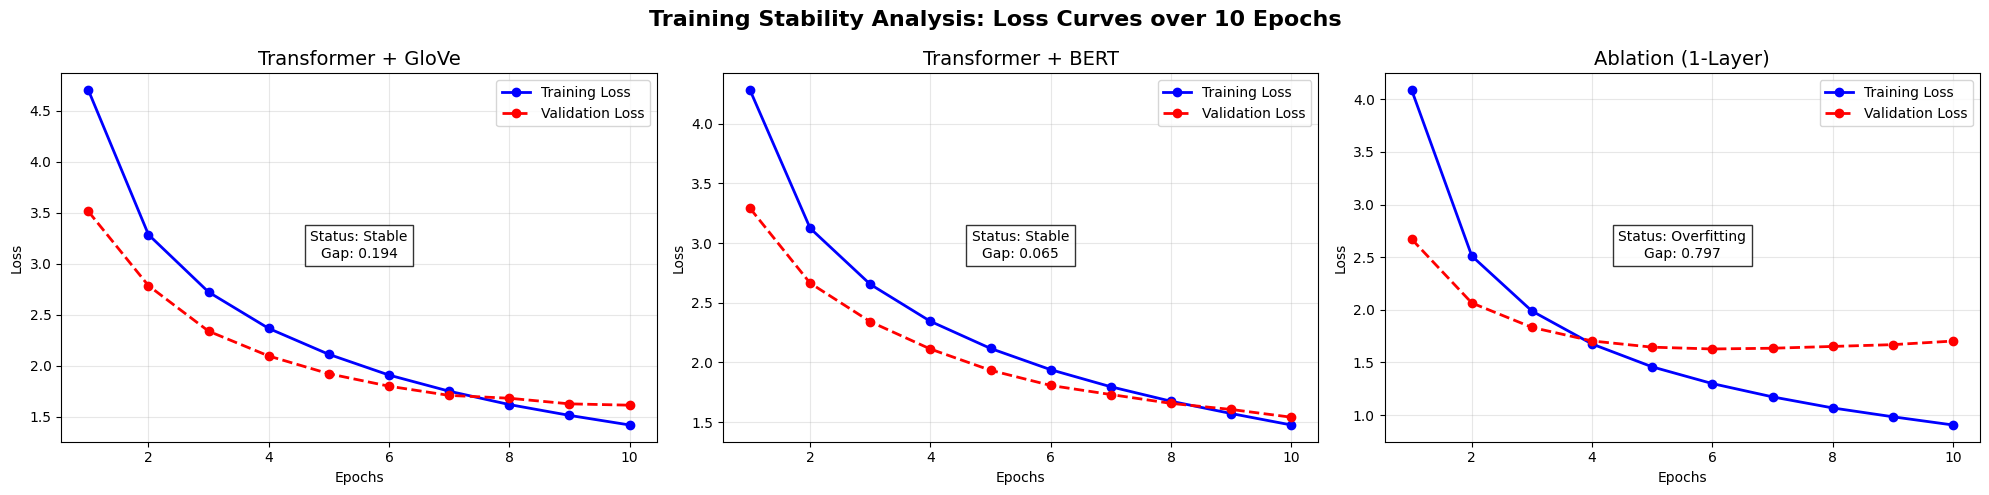

In [2]:
# --- STEP 14: Visualize Training Stability (Task 3d) ---
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from your training logs (Epochs 1-10)
epochs = np.arange(1, 11)

# 1. Transformer + GloVe Data
glove_train_loss = [4.703, 3.286, 2.723, 2.367, 2.113, 1.910, 1.752, 1.621, 1.515, 1.421]
glove_val_loss   = [3.514, 2.786, 2.340, 2.097, 1.923, 1.801, 1.711, 1.683, 1.628, 1.615]

# 2. Transformer + BERT Data
bert_train_loss = [4.281, 3.124, 2.654, 2.344, 2.117, 1.939, 1.796, 1.675, 1.572, 1.476]
bert_val_loss   = [3.291, 2.664, 2.341, 2.112, 1.934, 1.807, 1.731, 1.657, 1.606, 1.541]

# 3. Ablation (1-Layer) Data
abl_train_loss  = [4.087, 2.511, 1.988, 1.675, 1.458, 1.299, 1.173, 1.068, 0.984, 0.906]
abl_val_loss    = [2.671, 2.065, 1.833, 1.704, 1.645, 1.628, 1.635, 1.652, 1.669, 1.703]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Training Stability Analysis: Loss Curves over 10 Epochs', fontsize=16, fontweight='bold')

# Helper to plot
def plot_curve(ax, train, val, title):
    ax.plot(epochs, train, 'b-o', label='Training Loss', linewidth=2)
    ax.plot(epochs, val, 'r--o', label='Validation Loss', linewidth=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add stability metric (Gap)
    final_gap = val[-1] - train[-1]
    status = "Stable" if final_gap < 0.5 else "Overfitting"
    ax.text(0.5, 0.5, f"Status: {status}\nGap: {final_gap:.3f}", 
            transform=ax.transAxes, ha='center', bbox=dict(facecolor='white', alpha=0.8))

# Plot 1: GloVe
plot_curve(axes[0], glove_train_loss, glove_val_loss, "Transformer + GloVe")

# Plot 2: BERT
plot_curve(axes[1], bert_train_loss, bert_val_loss, "Transformer + BERT")

# Plot 3: Ablation
plot_curve(axes[2], abl_train_loss, abl_val_loss, "Ablation (1-Layer)")

plt.tight_layout()
plt.show()